<a href="https://colab.research.google.com/github/jvataidee/MachineLearning/blob/master/Avalia%C3%A7%C3%A3o_de_Risco_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_6ecb6c85550043f090237e5943d2647c~mv2.png/v1/fill/w_417,h_88,al_c,q_85,usm_0.66_1.00_0.01/Ativo%2023-8.webp" height="75px"></p>

**by: [João Ataíde](https://www.joaoataide.com)**
#**Avaliação de Risco de Crédito**


---


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_507dd1cb4e2c41b4941d9009868c6088~mv2.jpg"></p>


Das áreas que constituiem o banco, uma das que causam mais problemas e desconfortos são as taxas de inadimplência por parte das carteiras dos clientes. Assim, atividades de avaliação destas carteiras são obrigatórias e de extrema importancia para as intituições, causando deficities gigantescos na balança comercial intituicional e até mesmo nacional.

Geralmente, para as intituições cada um dos clientes possuem carteireias de crédito, na qual indica as possíbilide nas quais os clientes são capases financeiramente para o pagamento da dívida (emprestimos, cartão de crédito e outros), tal avaliação de carteira é informada como *ranking*.

Devido a isso, as intituições finaceiras estão investindo cada vez mais em novas tecnologias, com o intuito de desenvolver e aprimorando seus sistemas de avaliação, visando sempre minimizar os riscos de *default* (inadimplência) ou não cumprimento das obrigações e/ou condições de um empréstimo.

Sabendo dessa grande importância, as intituições finânciera têm apostado cada vez mais em modelos de *Machine Learning* para previnir a inadimplência de alguns clientes. Podemos destacar, uma das principais instituições financeira que aposta nesta tecnologia, sendo a [Nubank](https://nubank.com.br/sobre-nos) na qual possuí um grande time de *datascience*.

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/10/Nubank_logo.png" width="150px"></p>

Enúmeras aplicações podem ser feitas para previsão de risco de crédito, neste projeto em questão irei realizar a criação de um algoritimo para identificar a probabilidade de um cliente não coumprir com suas obrigações financeiras e deixar de pagar a sua fatura do Cartão de Crédito. Desta forma, espera-se que o modelo seja capaz de minimizar as perdas financeiras da empresa, assim como minimizando também os falsos positivos.



## Importação das bibliotecas e dados


  
Vale ressaltar que, geralmente as avaliações são feitas no momento em que o cliente solicita o cartão (normalmente no primeiro contato com a instituição), entretanto, usaremos um banco de dados já estabelecidos, no qual pode ser encontrado [neste link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0), tal *dataset* possuí 45.000 entradas e 43 colunas e constitui basicamente como um `.csv`.

In [45]:
#importar bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Biblitecas de preprocessamento e metricas
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning

#Bibliotecas de modelos
from sklearn.linear_model import LogisticRegression


# configurar a visualização
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [46]:
# importar os dados
df = "http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0"
df = pd.read_csv(df)

# ver as 5 primeiras entradas
print("Tamanho do dataset:", df.shape)
df.head()

Tamanho do dataset: (45000, 43)


,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


###Dicioário de variáveis

No caso desse projeto é de extrema importância a identificação do significado de cada umas das variáveis que serão utilizadas no trabalho, as quais podem ser vistas abaixo: 


* `id` -  identificação anônima, representa um valor único do cliente por cliente. 
* `target_default` - é a variável alvo, que utilizaremos para analisar o risco de *default* (inadimplência).
* As colunas `['score_3', 'score_4', 'score_5']` são numéricas, já `['score_1', 'score_2']` estão codificadas de alguma maneira. Teremos que verificar a frente se existe uma quantidade de classes que possa ser convertida em informação útil.
* existem outras variáveis que apresentam algum tipo de codificação, como `['reason', 'state', 'zip', 'channel', 'job_name', 'real_state']` que estão codificadas e também precisarão de alguma análise mais aprofundada para saber se é possível extrair alguma informação das mesmas.
* `profile_tags` - contém um dicionário um rótulo atribuídas a cada cliente.
* `target_fraud` -  seria a variável alvo para outro modelo, onde o objetivo seria a detecção de fraude.
* `lat_lon` - está em formato *string* contendo uma tupla com as coordenadas.

##Análise Exploratória

Como primeira fase de todo projeto, iniciarei a análise exploratória dos dados, senguindo esta ordem:



*   Valores Ausentes
*   Tipos de dados
*   Valores únicos
*   Balanceamento dos dados
*   Estatística Descritiva







Iniciando por aquele que representa a qualidade do *dataset*

In [47]:
##Valores Ausente
(df.isnull().sum()/df.shape[0]).sort_values(ascending = False)

target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_defaulted_loans       

Ao realizar esse cálculo podemos ver que algumas colunas como: `['target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year']` apresentam mais da metade dos dados ausentes, Já as camadas  `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possuem entre 25-34% do seus valores ausentes.

No entanto, a variável `target_default` contém valores nulos e será eliminada do *dataset*. Neste caso tal problema não compromete o projeto, pois esta variável é do tipo, a qual não representa muito interesse para a análise de risco de inadimplência.

Outro passo importante é saber se as variáveis estão no tipo corrento, sendo então necessário converter caso haja divergência.

In [48]:
#Ipo dos dados
df.dtypes

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                                     

Entretanto os dados aqui em questão não apresentaram tal problema, possibilitando seguir com a análise, identificando agora, quais os valores únicos de cada camada.

In [49]:
#Valores únicos

df.nunique().sort_values(ascending = False)

ids                                                 45000
profile_phone_number                                45000
score_6                                             45000
score_5                                             45000
score_4                                             45000
income                                              41211
reported_income                                     40025
application_time_applied                            35543
external_data_provider_first_name                   32886
job_name                                            32265
shipping_zip_code                                   28263
profile_tags                                        26131
lat_lon                                             22412
credit_limit                                        20928
reason                                              14874
last_amount_borrowed                                14325
external_data_provider_fraud_score                   1001
zip           

A contagem de valores únicos mostra que as colunas `external_data_provider_credit_checks_last_2_year` e `channel` apresentam um único valor possível, deste modo, se tornando camadas que não possibilitariam a contribuição para o modelo, podendo então ser descartadas.

Além destas duas camadas a variável`profile_phone_number`, também não apresenta siginificância para o modelo assim como o `ids`.

Vamos então ver o balancemanto de nossa variável algo `target_default`

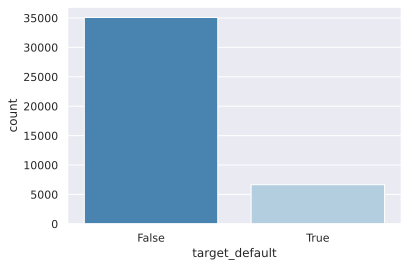

In [50]:
##plotar balanceamento
sns.countplot(df.target_default, palette="Blues_r" )
plt.show()

In [51]:
print("Proporção entre os inadimplentes (%)")

df.target_default.value_counts()/df.shape[0]*100

Proporção entre os inadimplentes (%)


False    77.955556
True     14.802222
Name: target_default, dtype: float64

Podemos ver então, que os dados apresentaram grande necesspidade de balanceamento, a qual realizarei mais a frente

Por último e não menos improtante, "Como está a estatística descritiva do dataset?"


In [52]:
#Estatística descritiva
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


As os cálculo das princiapais informações estatisticas apresentadas, podemos destacar algumas observações:

* A coluna `external_data_provider_credit_checks_last_2_year` possui valores mínimos, máximos e desvio-padrão iguais a zero.
* A coluna `reported_income` apresenta valores *inf*, que irão interferir na análise e modelo. Substituiremos valores do tipo `np.inf` por `np.nan` para trabalhar com os dados.
* A coluna `external_data_provider_email_seen_before` apresenta o valor mínimo de -999, o que é estranho ao se considerar as outras informações. Após verificar de maneira mais aprofundada, chegou-se a conclusão que esse dados são *outliers* ou foram tratados inadequadamente. Substituiremos os valores iguais a -999 por `np.nan`.

##Pré-processamento dos dados

Feita toda análise exploratória e avaliação de quais passos iremos fazer para construir o melhor modelo possível, podemos dá inicio então ao preprocessamento dos dados, que seguirão esta ordem ná primeira etapa:


*   Subistituir *inf* por *NaN*, na camada `reported_income`;
*   Descartar as colunas `ids`, `target_fraud`,`external_data_provider_credit_checks_last_2_year`, `channel` e `profile_phone_number`;
*   substituir -999 em `external_data_provider_email_seen_before` por *NaN*;
*   Elminar colunas sem informação aparente ou que demandam mais pesquisa;
*   Elminar as entradas onde `target_default` é igual a *NaN*.




In [53]:
#Copiando dataset
df_clear = df.copy()

In [54]:
#Subistituir inf por Nan
df_clear.reported_income = df_clear.reported_income.replace(np.inf, np.nan)

In [55]:
#eliminar camadas
df_clear.drop(["ids", "target_fraud", "external_data_provider_credit_checks_last_2_year", "channel", "profile_phone_number"], axis=1, inplace= True)

In [56]:
df_clear.head(2)

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...


In [57]:
#subistituir -999 por NaN
df_clear.loc[df_clear.external_data_provider_email_seen_before == -999, 'external_data_provider_email_seen_before'] = np.nan

In [58]:
df_clear.head(2)

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...


In [59]:
#Eliminar colunas sem informação ou que precisam de mais pesquisas
drop = ['reason', 'zip', 'job_name', 'external_data_provider_first_name',
            'lat_lon', 'shipping_zip_code', 'user_agent', 'profile_tags',
            'application_time_applied', 'email', 'marketing_channel',
             'shipping_state']

df_clear.drop(drop, axis = 1, inplace=True)

In [60]:
df_clear.head(2)

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,state,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,444,2,0.0,51.0,645,57849.0
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,346,1,0.0,17.0,243,4902.0


In [61]:
#Elminar as entradas onde target_default é igual a NaN.
df_clear.dropna(subset=["target_default"], inplace = True)

Com esse primeiro pre-processamento feito analisando as variáveis, pude então iniciar os pré-processamentos da entradas.

Esse *dataset* possui diversos dados ausentes e nulos, no entanto não temos muitas informações sobre os motivos desses problemas. Então, para solucionar isso irei subistituir os valores ausentes (*Nan*) por zero para as variáveis que  não possuem referênciais, como:  `last_amount_borrowed`, `last_borrowed_in_months` e `n_issues`. Já as demais, subistituirei pela mediana quando for númerica e pela a moda quando for categórica.

In [62]:
#Identificar categórica e númerica
df_num = df_clear.select_dtypes(exclude='object').columns
df_cat = df_clear.select_dtypes(include='object').columns

In [63]:
print("Variáveis númericas:",df_num)
print()
print("Variáveis categóricas:",df_cat)

Variáveis númericas: Index(['score_3', 'score_4', 'score_5', 'score_6', 'risk_rate',
       'last_amount_borrowed', 'last_borrowed_in_months', 'credit_limit',
       'income', 'ok_since', 'n_bankruptcies', 'n_defaulted_loans',
       'n_accounts', 'n_issues', 'application_time_in_funnel',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_fraud_score', 'reported_income'],
      dtype='object')

Variáveis categóricas: Index(['target_default', 'score_1', 'score_2', 'facebook_profile', 'state',
       'real_state'],
      dtype='object')


In [64]:
#Subistituir os valores ausentes por zero
df_clear.last_amount_borrowed.fillna(value = 0, inplace =True)
df_clear.last_borrowed_in_months.fillna(value = 0, inplace =True)
df_clear.n_issues.fillna(value = 0, inplace =True)

In [65]:
#Variável númerica
si =  SimpleImputer(missing_values=np.nan, strategy="median")
si = si.fit(df_clear.loc[:, df_num])
df_clear.loc[:, df_num] = si.transform(df_clear.loc[:, df_num])

In [66]:
#Variáveis categóricas
si = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
si = si.fit(df_clear.loc[:, df_cat])
df_clear.loc[:, df_cat] = si.transform(df_clear.loc[:, df_cat] )

Com todos pré-processamento feitos, pode ver então se existe algum dados ausento, constando que não, assim como você pode ver abaixo:

In [67]:
df_clear.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

In [68]:
print("Número de entradas:", df_clear.shape[0]," e Número de camadas:", df_clear.shape[1])

Número de entradas: 41741  e Número de camadas: 26


Agora para melhorar o desempenho do modelo, irei normalizar as variáveis numéricas usando StandardScaler e logo em seguida usar o algoritimo LabelEcoding para separar as categorias em forma de novas camadas.

In [107]:
#copiar dataset
df_model =  df_clear.copy()

In [108]:
y = df_model.target_default

In [109]:
#Identificar colunas númericas
df_num = df_model.drop('target_default', axis=1).select_dtypes(exclude= 'object').columns

#identificar colunas categoricas
df_cat = df_model.select_dtypes(include='object').columns

In [110]:
#Normalizar as colunas numericas
se = StandardScaler()
df_model[df_num] = se.fit_transform(df_model[df_num].values)

In [111]:
#Ecoding as colunas categoricas
le = LabelEncoder()

for col in df_cat:
  df_model[col + '_encoded'] = le.fit_transform(df_model[col])
  df_model.drop(col, axis=1, inplace=True)

In [112]:
df_model.head(2)

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_encoded,score_2_encoded,state_encoded,real_state_encoded
0,False,0.032154,0.563484,-0.832617,0.848870,1.039282,2.627224,1.11413,-1.031599,-0.116075,1.412589,-0.094349,-0.278592,-0.057693,1.604337,1.577495,1.341208,0.444809,-1.427247,1.322812,0.501783,-0.040691,0,10,44,1
1,False,0.213805,-0.924750,1.538588,-0.789902,-0.536149,-0.577743,-0.68792,0.283752,0.553756,-0.707920,1.191063,-0.278592,-0.057693,0.732520,0.937596,0.671463,-0.452701,-1.427247,-0.635622,-0.894101,-0.040691,3,16,47,1


In [113]:
print("Número de entradas:", df_model.shape[0]," e Número de camadas:", df_model.shape[1])

Número de entradas: 41741  e Número de camadas: 26


In [114]:
df_model.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_encoded,score_2_encoded,state_encoded,real_state_encoded
0,False,0.032154,0.563484,-0.832617,0.848870,1.039282,2.627224,1.11413,-1.031599,-0.116075,1.412589,-0.094349,-0.278592,-0.057693,1.604337,1.577495,1.341208,0.444809,-1.427247,1.322812,0.501783,-0.040691,0,10,44,1
1,False,0.213805,-0.924750,1.538588,-0.789902,-0.536149,-0.577743,-0.68792,0.283752,0.553756,-0.707920,1.191063,-0.278592,-0.057693,0.732520,0.937596,0.671463,-0.452701,-1.427247,-0.635622,-0.894101,-0.040691,3,16,47,1
2,True,0.122980,0.006361,-0.512003,1.294382,-0.043827,0.345051,1.11413,-0.196782,-0.115893,-0.707920,-0.094349,-0.278592,-0.057693,-0.139296,-1.302049,-1.652141,0.444809,0.700650,-1.096430,-1.512178,-0.040691,3,9,32,3
3,False,1.485366,0.500243,1.694857,-0.500560,0.251567,-0.577743,-0.68792,0.775941,-0.043057,-0.707920,-0.094349,3.365634,-0.057693,1.822291,1.737469,1.081511,1.342319,0.700650,0.573999,1.092082,-0.040691,0,21,23,3
4,False,1.394540,-0.481355,0.114978,1.816579,-1.126935,-0.577743,-0.68792,-0.196782,-0.211806,1.412589,-0.094349,-0.278592,-0.057693,0.078658,-1.302049,-0.052955,0.444809,0.700650,1.034807,-0.626730,-0.040691,2,1,47,3


Com todos os procedimentos feitos, pude fazer o calculo da correlação das variáveis, identificando uma correlação muito forte e negativa, como está apresentado abaixo:

In [77]:
df_model.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_encoded,score_2_encoded,state_encoded,real_state_encoded
count,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,4.174100e+04,41741.000000,41741.000000,41741.000000,41741.000000
mean,-1.998620e-16,-1.366934e-15,-1.765196e-16,-6.615563e-17,1.964721e-17,1.441897e-16,1.650884e-15,-3.358238e-16,-2.234330e-16,1.716097e-16,-8.413482e-17,-5.810471e-16,2.039329e-15,2.285491e-16,-4.520819e-16,-6.512762e-17,-9.645902e-16,1.070161e-15,-1.160679e-16,-5.842229e-17,-6.662774e-19,1.912149,17.186483,27.814331,2.092499
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.485103,9.112314,16.201360,1.114136
min,-3.146747e+00,-4.339255e+00,-1.733471e+00,-3.916791e+00,-2.899294e+00,-5.777428e-01,-6.879198e-01,-1.031599e+00,-1.267891e+00,-7.079201e-01,-2.379525e+00,-2.785925e-01,-5.769276e-02,-2.318838e+00,-1.302049e+00,-1.693146e+00,-1.350210e+00,-1.427247e+00,-1.672439e+00,-1.737881e+00,-4.069141e-02,0.000000,0.000000,0.000000,0.000000
25%,-6.944521e-01,-6.734986e-01,-8.602449e-01,-6.721703e-01,-7.330775e-01,-5.777428e-01,-6.879198e-01,-4.577595e-01,-5.178143e-01,-7.079201e-01,-9.434883e-02,-2.785925e-01,-5.769276e-02,-7.931587e-01,-1.302049e+00,-8.730501e-01,-4.527005e-01,-1.427247e+00,-8.660255e-01,-8.628496e-01,-4.069141e-02,1.000000,10.000000,12.000000,1.000000
50%,-5.867193e-02,3.496056e-03,2.630495e-03,5.824409e-03,-4.382670e-02,-5.777428e-01,-6.879198e-01,-1.967819e-01,-2.111788e-01,-7.079201e-01,-9.434883e-02,-2.785925e-01,-5.769276e-02,-1.392962e-01,1.377228e-01,1.718479e-03,4.448094e-01,7.006495e-01,-2.010605e-03,5.237095e-03,-4.069141e-02,2.000000,16.000000,31.000000,3.000000
75%,6.679340e-01,6.709880e-01,8.616107e-01,6.696470e-01,6.454241e-01,3.838015e-01,1.114130e+00,1.271720e-01,2.669920e-01,1.412589e+00,-9.434883e-02,-2.785925e-01,-5.769276e-02,5.145663e-01,6.176468e-01,8.696529e-01,4.448094e-01,7.006495e-01,8.620043e-01,8.559620e-01,-4.069141e-02,3.000000,26.000000,44.000000,3.000000
max,5.845001e+00,4.388306e+00,1.737555e+00,4.217775e+00,5.962502e+00,3.910761e+00,2.315496e+00,1.381085e+01,9.431740e+01,1.412589e+00,7.689531e+00,1.794254e+01,6.232970e+01,8.360916e+00,6.536709e+00,1.723919e+00,1.342319e+00,7.006495e-01,1.783620e+00,1.734466e+00,2.457523e+01,6.000000,34.000000,49.000000,4.000000


In [115]:
#Criando uma mascara da diagonal superior
mask = np.zeros_like(df_model.corr())
mask[np.triu_indices_from(mask)] = True

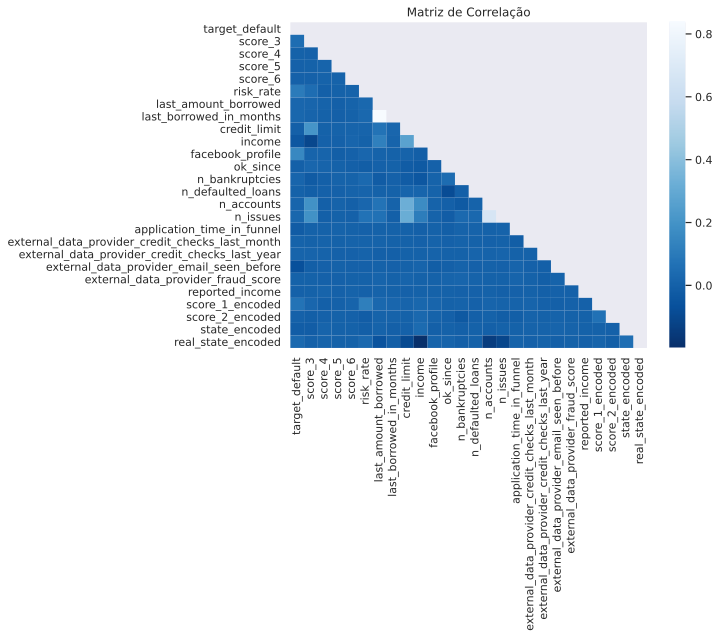

In [116]:
#Plotar matriz de correlação
plt.figure(figsize = (8,6))
plt.title("Matriz de Correlação")

sns.heatmap(df_model.corr(), mask= mask, cmap = 'Blues_r' )
plt.show()

Com isso, pode-se separar os dataset de treino e teste e dá inicio ao treino do modelo.

In [117]:
# separar as variáveis independentes da variável alvo
X = df_model.drop('target_default', axis=1).select_dtypes(exclude='object')
y = df_model['target_default']

In [118]:
# dividir o dataset entre treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3)

##Contruindo o Modelo

###Descidindo o modelo

Com base em avaliação de outros cientistas de dados e na [literatura ](https://repositorio.iscte-iul.pt/bitstream/10071/20293/1/Master_Andre_Luiz_Monteiro.pdf)identifiquei que o melhor modelo para esse tipo de problema, no caso o mais utilizado é o RandomForest. No entanto, não realizei uma análise mais aprofundada sobre as variáveis e nem um *tunning* de parâmetros, mas construído um modelo simples para servir de *baseline*.

Então, para identificar o melhor modelo de RF, realizei diversos testes procurando o melhor estimardos para utilizar.



In [ ]:
#Balanceamento dos dados
rus = RandomUnderSampler()
X_treino_rus, y_treino_rus = rus.fit_sample(X_treino,y_treino)

In [124]:
#Construção do modelo
kfold = StratifiedKFold(n_splits=10, shuffle=True)

forest = RandomForestClassifier()

#qual melhro critério
param_grid = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(forest, param_grid, scoring = 'recall', cv=kfold)
result = search.fit(X_treino_rus, y_treino_rus)

# ver resultados
print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.6194047476817601 para {'criterion': 'gini'}


In [91]:
forest = RandomForestClassifier(criterion='gini')

#qual melhor numero de estimadores
param_grid = {'n_estimators': range(50, 500, 50)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_treino_rus, y_treino_rus)

# ver resultados
print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.63461093088015 para {'n_estimators': 400}


In [92]:
forest = RandomForestClassifier(criterion='gini', n_estimators=400)

#qual melhor numero de estimadores
param_grid = {'min_samples_split': range(2, 10, 2)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_treino_rus, y_treino_rus)

# ver resultados
print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.6412508845613035 para {'min_samples_split': 6}


In [94]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=400,min_samples_split = 6)

#qual melhor numero de estimadores
param_grid = {'min_samples_leaf': range(1, 6, 2)}

search = GridSearchCV(forest, param_grid, scoring='recall', cv=kfold)
result = search.fit(X_treino_rus, y_treino_rus)

# ver resultados
print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.6369645532161271 para {'min_samples_leaf': 5}


In [120]:
#Modelo Final
forest = RandomForestClassifier(criterion='entropy', n_estimators=400,min_samples_split = 6)
forest.fit(X_treino, y_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [121]:
#Frazer predições
#Mudar a escala do X_test
X_teste = scala.transform(X_teste)
y_pred =  forest.predict(X_teste)

In [122]:
#Relatorio de classificação
print(classification_report(y_teste, y_pred))
print("Área sobre a curva ASC:", roc_auc_score(y_teste,y_pred))

              precision    recall  f1-score   support

       False       0.84      0.96      0.90     10465
        True       0.31      0.10      0.15      2058

    accuracy                           0.82     12523
   macro avg       0.57      0.53      0.52     12523
weighted avg       0.76      0.82      0.77     12523

Área sobre a curva ASC: 0.5271465298971953


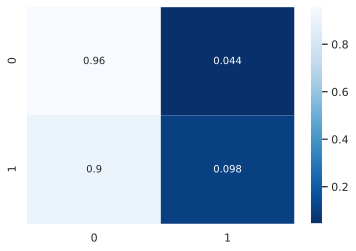

In [123]:
#Plotar matriz de confusão
sns.heatmap(confusion_matrix(y_teste, y_pred, normalize='true'), annot=True, cmap="Blues_r");

Lembra-se que o *dataset* utilizado neste projeto não foi balanceado, o que pode gerar métricas que não representam a realidade da situação problemática do mundo real.

No entanto, o mesmo apresentou valores bem elevados de Verdadeiros Positivos e Verdadeiros Negativos, no entanto pode ter sido um overfitting das predições. 

#Conclusão
 
Neste projeto, realizei diversos procedimento para a contrução de um modelo de predição de risco de crédito
